# Practical Work - Filter Banks - Hugo Queniat

In [162]:
#Imports

import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyaudio

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write
import scipy.signal
import time
import scipy.linalg

## 1 Two-channel filter bank

### 1.2 Synthesis of a half-band filter

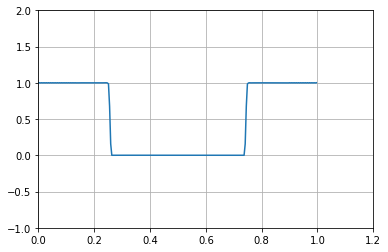

In [165]:
#1

Fs=32000
length = 251
nu_c = 0.25
nu_a = 1.05*nu_c
h_halfband= scipy.signal.remez(length,[0, nu_c, nu_a, 0.5],[1,0])
H_halfband = np.fft.fft(h_halfband,length)
freq = [k/length for k in range(length)]

def plot_response(f,tab):
	fig = plt.figure()
	ax = fig.add_subplot(111)
	ax.plot(tab, np.abs(f))
	ax.set_ylim(-1, 2)
	ax.set_xlim(0, 1.2)
	ax.grid(True)

def plot_response_db(f,tab):
	fig = plt.figure()
	ax = fig.add_subplot(111)
	ax.plot(tab, 20*np.log10(np.abs(f)))
	ax.set_ylim(-40, 10)
	ax.set_xlim(0, 0.5)
	ax.grid(True)

plot_response(H_halfband,freq)
	

False


'\nThe half-band condition does not hold.\n'

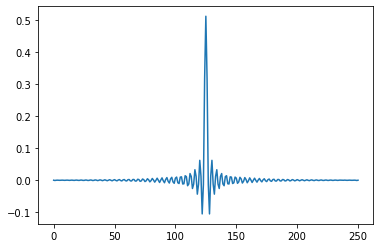

In [166]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot([k for k in range(length)], h_halfband)
flag = True
for k in range(1,length,2):
	flag = flag and (h_halfband[k]==0)
print(flag)

"""
The half-band condition does not hold.
"""

" The Chebyshev's alternance property does not hold any more "

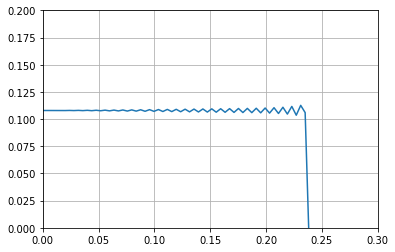

In [167]:
#2
h_modify = h_halfband.copy()
for k in range(1,length,2):
	if k!=((length-1)/2):
		h_modify[k] = 0

def plot_response_db(f,tab):
	fig = plt.figure()
	ax = fig.add_subplot(111)
	ax.plot(tab, 20*np.log10(np.abs(f)))
	ax.set_ylim(0, 0.2)
	ax.set_xlim(0, 0.3)
	ax.grid(True)

plot_response_db(np.fft.fft(h_modify, length), freq)

""" The Chebyshev's alternance property does not rigorously hold any more """


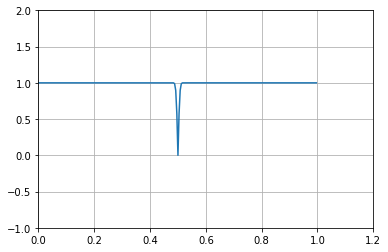

In [159]:
#3
length = 250
nu_c = 0.48
freq = [k/length for k in range(length)]
v = scipy.signal.remez(length,[0, nu_c, 0.5, 0.5],[1,0])
V = np.fft.fft(v,length)
plot_response(V,freq) #affichage de V qui est un "passe-tout" sauf pour la fréquence 1/2

### 1.3 Raising and factorization of the half-band filter

-3.066502340942634e-08


<ipython-input-163-b333122e966e>:8: ComplexWarning: Casting complex values to real discards the imaginary part
  V_R[k] = np.exp(2j*np.pi*k*(length-1)/(length*2)) *V[k]


'\nWe thus see that the non negative property doest not hold on G_R, (a term is negative) therefore one cannot factorize it the way we want it\n'

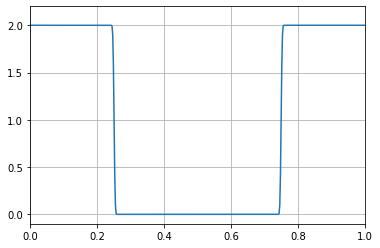

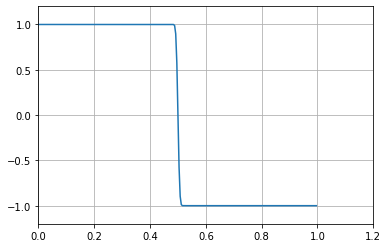

In [163]:
#4
nu_c = 0.48
freq2 = [k/(2*length-1) for k in range(2*length-1)]
G_R = np.zeros(2*length-1)
V_R = np.zeros(length)
flag = 0
for k in range(length): #calcul de la TF de V_R à partir de celle de V
	V_R[k] = np.exp(2j*np.pi*k*(length-1)/(length*2)) *V[k]
for k in range(2*length-1): #obtention de la TF de G_R à partir de celle de V_R
	if k<(length):
		G_R[k]=V_R[k]+1
	if k >=length:
		G_R[k]=V_R[2*length-1-k]+1
	if (G_R[k]<0) and (flag==0 or G_R[k]<G_R[flag]):
		flag = k
def plot_response_bounds(f,tab,x_min,x_max, y_min, y_max):
	fig = plt.figure()
	ax = fig.add_subplot(111)
	ax.plot(tab, f)
	ax.set_ylim(y_min, y_max)
	ax.set_xlim(x_min, x_max)
	ax.grid(True)
plot_response_bounds(G_R,freq2,0, 1, -0.1, 2.2)  #affichage de la TF de G_R sur le premier graphe
plot_response_bounds(V_R,freq,0, 1.2, -1.2, 1.2) #affichage de la TF de V_R sur le second graphe
if flag >0:
	print(G_R[flag]) 

"""
We thus see that the non negative property doest not hold on G_R, (a term is negative) therefore one cannot factorize it the way we want it
"""

0


'\nLa réponse fréquentielle a bien été relevée\n'

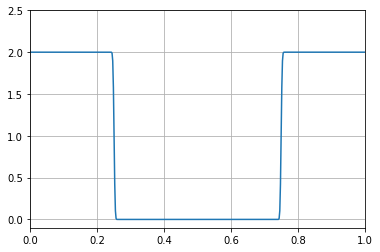

In [164]:
#5
G_R_nonnegative = np.zeros(2*length-1)
epsilon = 100*G_R[flag]
test=0
for k in range(2*length-1):
	G_R_nonnegative[k] = G_R[k] - epsilon   # on ajoute à tous les termes un bon epsilon pour qu'ils deviennent tous positifs
	if (G_R_nonnegative[k]<0) and (test==0 or G_R_nonnegative[k]<G_R_nonnegative[test]):
		test=k
print(test)
plot_response_bounds(G_R_nonnegative,freq2,0, 1, -0.1, 2.5)

"""
La réponse fréquentielle a bien été relevée
"""

In [ ]:
#6 Computing h0

# first compute g + from GR 
G_R_impulse = np.fft.ifft(G_R,2*length-1)
g = np.zeros(2*length-1) #le décalage est repris sur GR qui en TF est égal à G * une onde de fourier
for k in range(2*length-1):
	if k==(length-1):
			g[k] = G_R_impulse[(k-length-1)%(2*length-1)] - epsilon
	else: 
		g[k] = G_R_impulse[(k-length-1)%(2*length-1)]



h = np.zeros(length)
h[0] = 1
flagBoolean = False
while not flagBoolean :
	hnew = np.zeros(length)
	hnew[length-1] = g[0]/h[0]
	for k in range(1,length):
		result = g[k]
		for i in range(1,k+1):
			result = result - h[i] * h[length-1-(k-i)]
		hnew[length-1-k] = result/h[0]
	norm2 = 0
	for k in range(length):
		norm2 += hnew[k]**2
	hnew = hnew *((abs(g[length-1])/norm2)**0.5)
	norm2 = 0
	for k in range(length):
		norm2 += (hnew[k]-h[k])**2
	print(max(hnew-h))
	flagBoolean = (norm2 < 0.000000000000000000000000000001)
	h = hnew


Je ne suis pas parvenu à exprimer le filtre h.

## 2 Transmultiplexer

### Audio treatment

In [105]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

In [106]:
data_path = os.getcwd()
filename = 'femme3.wav'
sound = os.path.join(data_path, filename) 

In [108]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=330750, comptype='NONE', compname='not compressed')


In [ ]:
play = True
if play :
    play_sound(sound) 

In [110]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [112]:
signal_femme = x

In [113]:
data_path = os.getcwd()
filename = 'homme3.wav'
sound = os.path.join(data_path, filename) 

In [114]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=330750, comptype='NONE', compname='not compressed')


In [ ]:
play = True
if play :
    play_sound(sound) 

In [116]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
y = np.array(data)

In [117]:
signal_homme = y

In [118]:
timestep = 1/float(Fs)
times = np.arange(x.shape[0])*timestep

In [ ]:
plot_sound(x, times)

### Question 1

In [121]:
#Input

def Insertion_of_Zeros(x,L):
	w=np.zeros(x.shape[0]*L)
	w[::L] = x
	return w
#Application de F sur les signaux ou les zeros ont été insérés
S_0_tilde = scipy.signal.lfilter([0,1], [1], Insertion_of_Zeros(signal_femme,2))
S_1_tilde = scipy.signal.lfilter([1],[1], Insertion_of_Zeros(signal_homme,2))

X_afterC = scipy.signal.lfilter([0,1], [1], (S_0_tilde + S_1_tilde)) #Somme et application de C

write('x(z).wav', Fs, np.array(X_afterC, dtype=np.int16)) # to write a new wave file



#### Ecouter X(z)

In [ ]:
data_path = os.getcwd()
filename = 'x(z).wav'
sound = os.path.join(data_path, filename) 

In [ ]:
wavefile = load_sound(sound)
print(wavefile.getparams())

In [ ]:
play = True
if play :
    play_sound(sound) 

On ne parvient pas à réellement distinguer le dialogue, c'est presque inaudible.

#### Ecouter les sorties

On observe que les sorties sont parfaites et apparaissent dans les bons canaux

##### S0(z)

In [122]:
#Output 1

S_0 = (scipy.signal.lfilter([1], [1], X_afterC))[::2] #application de H et decimation par 2

write('S0.wav', Fs, np.array(S_0, dtype=np.int16)) # to write a new wave file

In [123]:
data_path = os.getcwd()
filename = 'S0.wav'
sound = os.path.join(data_path, filename) 

In [124]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=330750, comptype='NONE', compname='not compressed')


In [ ]:
play = True
if play :
    play_sound(sound) 

##### S1(z)

In [69]:
#Output 2

S_1 = (scipy.signal.lfilter([0,1], [1], X_afterC))[::2]  #application de H et decimation par 2

write('S1.wav', Fs, np.array(S_1, dtype=np.int16)) # to write a new wave file

In [126]:
data_path = os.getcwd()
filename = 'S1.wav'
sound = os.path.join(data_path, filename) 

In [127]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=330750, comptype='NONE', compname='not compressed')


In [ ]:
play = True
if play :
    play_sound(sound) 

### Question 2

#### a)

Si $\alpha$ = 0.9, alors $\alpha$ est de module strictement inférieur à 1 et on peut donc construire D causal tel que : $ D(z) = \frac{dz^{-n_0}}{1-\alpha z^{-1}}$

In [129]:
#Input

X_afterC =  scipy.signal.lfilter([1,-0.9], [1], (S_0_tilde + S_1_tilde)) #application de H et decimation par 2
X_afterD = scipy.signal.lfilter([0,0,0,4], [1, -0.9], X_afterC) #Application du correctif D

write('newx(z).wav', Fs, np.array(X_afterC, dtype=np.int16)) # to write a new wave file


##### Ecouter X(z)

In [130]:
data_path = os.getcwd()
filename = 'newx(z).wav'
sound = os.path.join(data_path, filename) 

In [131]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=661500, comptype='NONE', compname='not compressed')


In [ ]:
play = True
if play :
    play_sound(sound) 

Après l'application de D, de nouveau le signal est peu audible.

##### Ecouter les sorties

La reconstruction est parfaite, les signaux reviennent dans les bon canaux.

###### S0(z)

In [134]:
#Output 1

S_0_new = (scipy.signal.lfilter([1], [1], X_afterD))[::2]

write('S0new.wav', Fs, np.array(S_0, dtype=np.int16)) # to write a new wave file

In [135]:
data_path = os.getcwd()
filename = 'S0new.wav'
sound = os.path.join(data_path, filename) 

In [136]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=330750, comptype='NONE', compname='not compressed')


In [ ]:
play = True
if play :
    play_sound(sound) 

###### S1(z)

In [138]:
#Output 2

S_1_new = (scipy.signal.lfilter([0,1], [1], X_afterD))[::2]

write('S1new.wav', Fs, np.array(S_1, dtype=np.int16)) # to write a new wave file

In [139]:
data_path = os.getcwd()
filename = 'S1new.wav'
sound = os.path.join(data_path, filename) 

In [140]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=330750, comptype='NONE', compname='not compressed')


In [ ]:
play = True
if play :
    play_sound(sound) 

#### b)

En revanche, si $\alpha$ = 1.2, alors il est de module strictement supérieur à 1 et D ne serait plus causal si on l'implémentait comme dans a).

A l'inverse on peut l'écrire comme produit d'un "passe-partout" (dont la TF est de module 1) par le produit C(z)D(z) recherché :

$ D(z) = \frac{z^{-1}-\alpha}{1-\alpha z^{-1}} dz^{-n_{0}}$

In [142]:
#Input

X_afterC =  scipy.signal.lfilter([1,-0.9], [1], (S_0_tilde + S_1_tilde))
X_afterD = scipy.signal.lfilter([0,0,0,-0.9*4,4], [1, -0.9], X_afterC)

write('new2x(z).wav', Fs, np.array(X_afterC, dtype=np.int16)) # to write a new wave file


##### Ecouter X(z)

In [143]:
data_path = os.getcwd()
filename = 'new2x(z).wav'
sound = os.path.join(data_path, filename) 

In [144]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=661500, comptype='NONE', compname='not compressed')


In [ ]:
play = True
if play :
    play_sound(sound) 

Pareiil que précédemment, après le D le signal n'est pas audible.

##### Ecouter les sorties

La reconstruction semble de nouveau parfaite, les signaux reviennent dans les bons canaux et on ne distingue aucune différence à l'oreille

###### S0(z)

In [146]:
#Output 1

S_0_new2 = (scipy.signal.lfilter([1], [1], X_afterD))[::2]

write('S0new2.wav', Fs, np.array(S_0, dtype=np.int16)) # to write a new wave file

In [147]:
data_path = os.getcwd()
filename = 'S0new2.wav'
sound = os.path.join(data_path, filename) 

In [148]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=330750, comptype='NONE', compname='not compressed')


In [ ]:
play = True
if play :
    play_sound(sound) 

###### S1(z)

In [150]:
#Output 2

S_1_new2 = (scipy.signal.lfilter([0,1], [1], X_afterD))[::2]

write('S1new2.wav', Fs, np.array(S_1, dtype=np.int16)) # to write a new wave file

In [151]:
data_path = os.getcwd()
filename = 'S1new2.wav'
sound = os.path.join(data_path, filename) 

In [152]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=330750, comptype='NONE', compname='not compressed')


In [ ]:
play = True
if play :
    play_sound(sound) 

### Question 3